imports

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import keras_nlp

loading the dataset

In [3]:
imdb = tfds.load("imdb_reviews", as_supervised=True, data_dir="data", download=False)

I0000 00:00:1755283766.072926   34386 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5386 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [5]:
train_reviews = imdb['train'].map(lambda review, label: review)
train_labels = imdb['train'].map(lambda review, label: label)

test_reviews = imdb['test'].map(lambda review, label: review)
test_labels = imdb['test'].map(lambda review, label: label)

In [6]:
subword_tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary='subwords/imdb_vocab_subwords.txt'
)

2025-08-16 00:21:05.640733: W tensorflow_text/core/kernels/fast_wordpiece_tokenizer_model_builder.cc:324] The empty string is found in the vocabulary, which takes place in the token id space but will never be used in the result. Consider cleaning it from the vocabulary.
2025-08-16 00:21:05.641207: W tensorflow_text/core/kernels/fast_wordpiece_tokenizer_model_builder.cc:336] The empty suffix token is found in the vocabulary, which takes place in token id space but will (almost) never be used in the result. Consider cleaning it from the vocabulary.


hyperparameters

In [7]:
SHUFFLE_BUFFER_SIZE = 10000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE
BATCH_SIZE = 64
PADDING_TYPE = 'pre'
TRUNC_TYPE = 'post'

data pipeline

In [8]:
def padding_func(sequences):

  sequences = sequences.ragged_batch(batch_size=sequences.cardinality())

  sequences = sequences.get_single_element()

  padded_sequences = tf.keras.utils.pad_sequences(sequences.numpy(), truncating=TRUNC_TYPE, padding=PADDING_TYPE)

  padded_sequences = tf.data.Dataset.from_tensor_slices(padded_sequences)

  return padded_sequences

In [9]:
train_sequences_subword = train_reviews.map(lambda review: subword_tokenizer.tokenize(review)).apply(padding_func)
test_sequences_subword = test_reviews.map(lambda review: subword_tokenizer.tokenize(review)).apply(padding_func)

train_dataset_vectorized = tf.data.Dataset.zip(train_sequences_subword,train_labels)
test_dataset_vectorized = tf.data.Dataset.zip(test_sequences_subword,test_labels)

train_dataset_final = (train_dataset_vectorized
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .cache()
                       .prefetch(buffer_size=PREFETCH_BUFFER_SIZE)
                       .batch(BATCH_SIZE)
                       )

test_dataset_final = (test_dataset_vectorized
                      .cache()
                      .prefetch(buffer_size=PREFETCH_BUFFER_SIZE)
                      .batch(BATCH_SIZE)
                      )

2025-08-16 00:22:44.856431: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


build and compile the model

In [10]:
BATCH_SIZE = 1
TIMESTEPS = 20
FEATURES = 20
FILTERS = 128
KERNEL_SIZE = 5

print(f'batch_size: {BATCH_SIZE}')
print(f'timesteps (sequence length): {TIMESTEPS}')
print(f'features (embedding size): {FEATURES}')
print(f'filters: {FILTERS}')
print(f'kernel_size: {KERNEL_SIZE}')

random_input = np.random.rand(BATCH_SIZE,TIMESTEPS,FEATURES)
print(f'shape of input array: {random_input.shape}')

conv1d = tf.keras.layers.Conv1D(filters=FILTERS, kernel_size=KERNEL_SIZE, activation='relu')
result = conv1d(random_input)
print(f'shape of conv1d output: {result.shape}')

gmp = tf.keras.layers.GlobalMaxPooling1D()
result = gmp(result)
print(f'shape of global max pooling output: {result.shape}')

batch_size: 1
timesteps (sequence length): 20
features (embedding size): 20
filters: 128
kernel_size: 5
shape of input array: (1, 20, 20)


I0000 00:00:1755283993.507665   34386 cuda_dnn.cc:529] Loaded cuDNN version 91002


shape of conv1d output: (1, 16, 128)
shape of global max pooling output: (1, 128)


In [11]:
EMBEDDING_DIM = 64
FILTERS = 128
KERNEL_SIZE = 5
DENSE_DIM = 64

model = tf.keras.Sequential([
    tf.keras.Input(shape=(None,)),
    tf.keras.layers.Embedding(subword_tokenizer.vocabulary_size(), EMBEDDING_DIM),
    tf.keras.layers.Conv1D(filters=FILTERS, kernel_size=KERNEL_SIZE, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(DENSE_DIM, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, None, 64)       │       488,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, None, 128)      │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 538,049 (2.05 MB)

 Trainable params: 538,049 (2.05 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

training the model

In [13]:
NUM_EPOCHS = 10

history = model.fit(train_dataset_final, epochs=NUM_EPOCHS, validation_data=test_dataset_final)

Epoch 1/10


I0000 00:00:1755284048.111865   34487 service.cc:152] XLA service 0x7fb4000be440 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755284048.111881   34487 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-08-16 00:24:08.129860: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


  7/391 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.5067 - loss: 0.6943

I0000 00:00:1755284050.396794   34487 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


391/391 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.6610 - loss: 0.5747 - val_accuracy: 0.8845 - val_loss: 0.2718
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.9028 - loss: 0.2425 - val_accuracy: 0.9001 - val_loss: 0.2481
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.9613 - loss: 0.1163 - val_accuracy: 0.8845 - val_loss: 0.3294
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.9814 - loss: 0.0591 - val_accuracy: 0.8953 - val_loss: 0.3300
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.9910 - loss: 0.0317 - val_accuracy: 0.8978 - val_loss: 0.3434
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.9996 - loss: 0.0067 - val_accuracy: 0.8990 - val_loss: 0.3676
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.8998 - val_loss: 0.3813
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 1.0000 - loss: 6.9108e-04 - val_accuracy

visualize the results

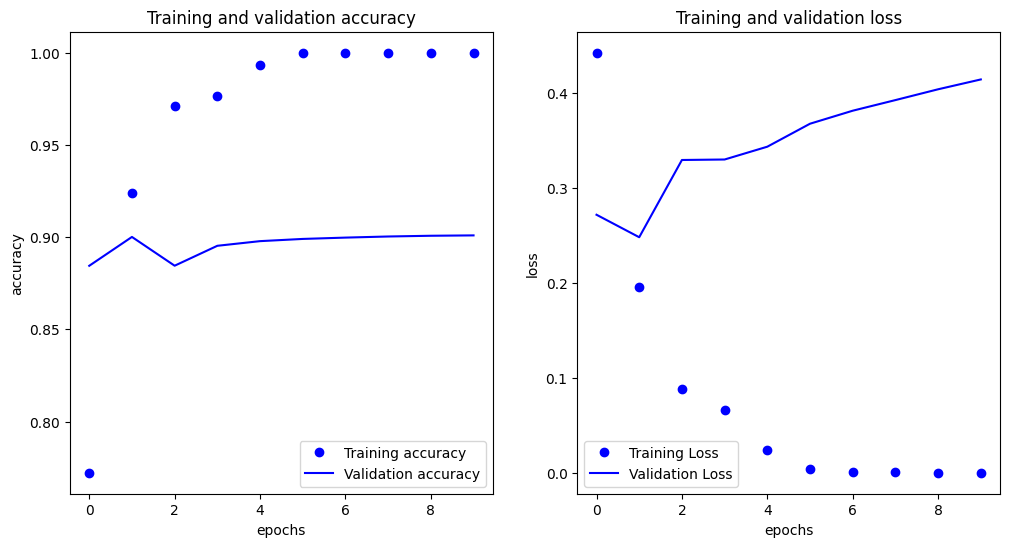

In [14]:
def plot_loss_acc(history):

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  fig, ax = plt.subplots(1,2, figsize=(12, 6))
  ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
  ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
  ax[0].set_title('Training and validation accuracy')
  ax[0].set_xlabel('epochs')
  ax[0].set_ylabel('accuracy')
  ax[0].legend()

  ax[1].plot(epochs, loss, 'bo', label='Training Loss')
  ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
  ax[1].set_title('Training and validation loss')
  ax[1].set_xlabel('epochs')
  ax[1].set_ylabel('loss')
  ax[1].legend()

  plt.show()

plot_loss_acc(history)

obvious case of overfitting but still fun to tinker with convolutions